In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np

from models import SegmentationModel
from dataloader import get_dataloader, walk_through_dir
from pathlib import Path
import random

In [64]:
# check if gpu available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [65]:
data_path = "/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/"
walk_through_dir(Path(data_path))

There are 2 directories and 2 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data'.
There are 7 directories and 0 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well5_225locations'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well4_225locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well6_135locations'.
There are 0 directories and 2156 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well3_200locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well7_

In [66]:
image_dirs = [data_path + 'brightfield/Alexa488_Fibroblasts_well1_50locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well2_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well3_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well4_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well5_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well6_135locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well7_135locations']
mask_dir = data_path + 'masks'

In [67]:
def set_seed(seed=111):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
    random.seed(seed)
    np.random.seed(seed)

In [68]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = data_transform

train_dataloader, val_dataloader, test_dataloader = get_dataloader(image_dirs, mask_dir, data_transform, mask_transform, display_sample=False)

Number of images in the trainset: 889
Number of images in the valset: 223
Number of images in the testset: 50


In [69]:
# init architecture
model = SegmentationModel()

# loading the pretrained model
state_dict = torch.load('segmentation_model_UNet_train80%_channels0_1_2_3_4_5_6_7_8_9_10.pth', map_location=torch.device('cpu'))

# load weights into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()
model = model.to(device)

/tmp/ipykernel_3055721/1518508697.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('segmentation_model_UNet_train80%_channels0_1_2_3_4_5_6_7_8_9_1

In [75]:
# Sample evaluation
batch = next(iter(test_dataloader))  # Get one batch
images, masks = batch

set_seed()

random_idx = random.randint(0, images.size(0) - 1)  # Random index within batch size
random_images = images.to(device)
random_mask = masks[random_idx].to(device) # Select only one random sample to plot

model.eval()

SegmentationModel(
  (enc1): Sequential(
    (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [76]:
# Extract the random image
random_image = images[random_idx].unsqueeze(0).to(device)  # Add batch dimension
random_mask = masks[random_idx].to(device)  # Ground truth mask for the random sample

# Set up input_tensor with requires_grad=True
input_tensor = random_image.clone().detach()
input_tensor.requires_grad = True

# Perform forward pass
output = model(input_tensor)

In [77]:
# forward pass
# output = model(input_tensor)
binary_output = (output > 0.5).float() # Make binary segmentation

# define a target
# target = output[0, 0].mean()

masked_output = output[0, 0] * (output[0, 0] > 0.5).float()  # Mask without breaking gradients
target = masked_output.mean()

# Backward pass to compute gradients
target.backward()

9.947598300641403e-11
0.0019005679059773684


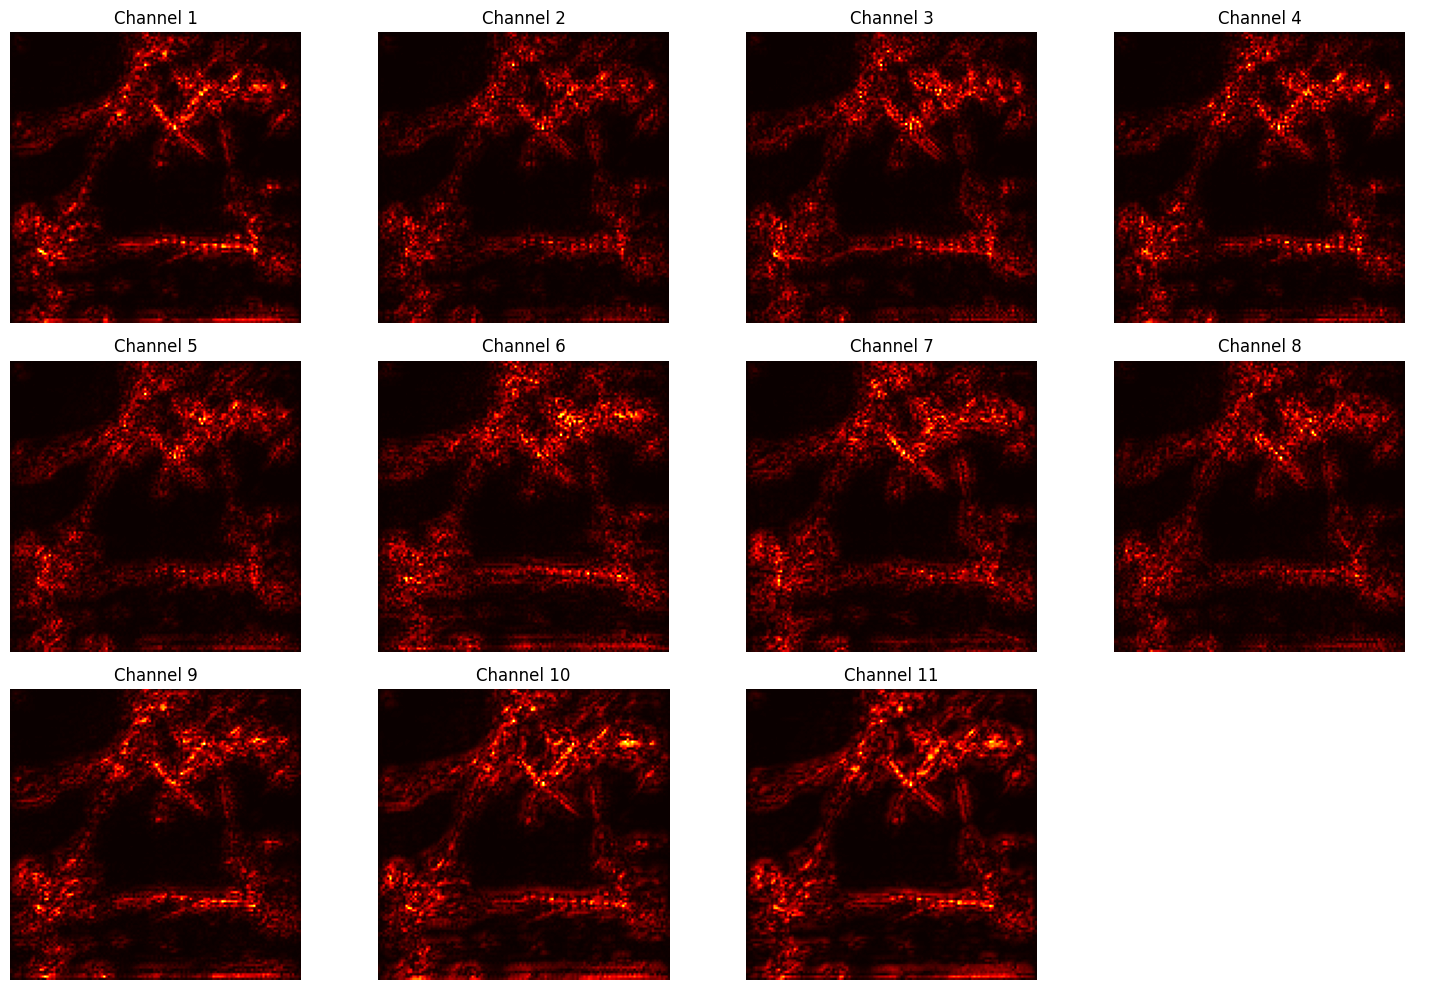

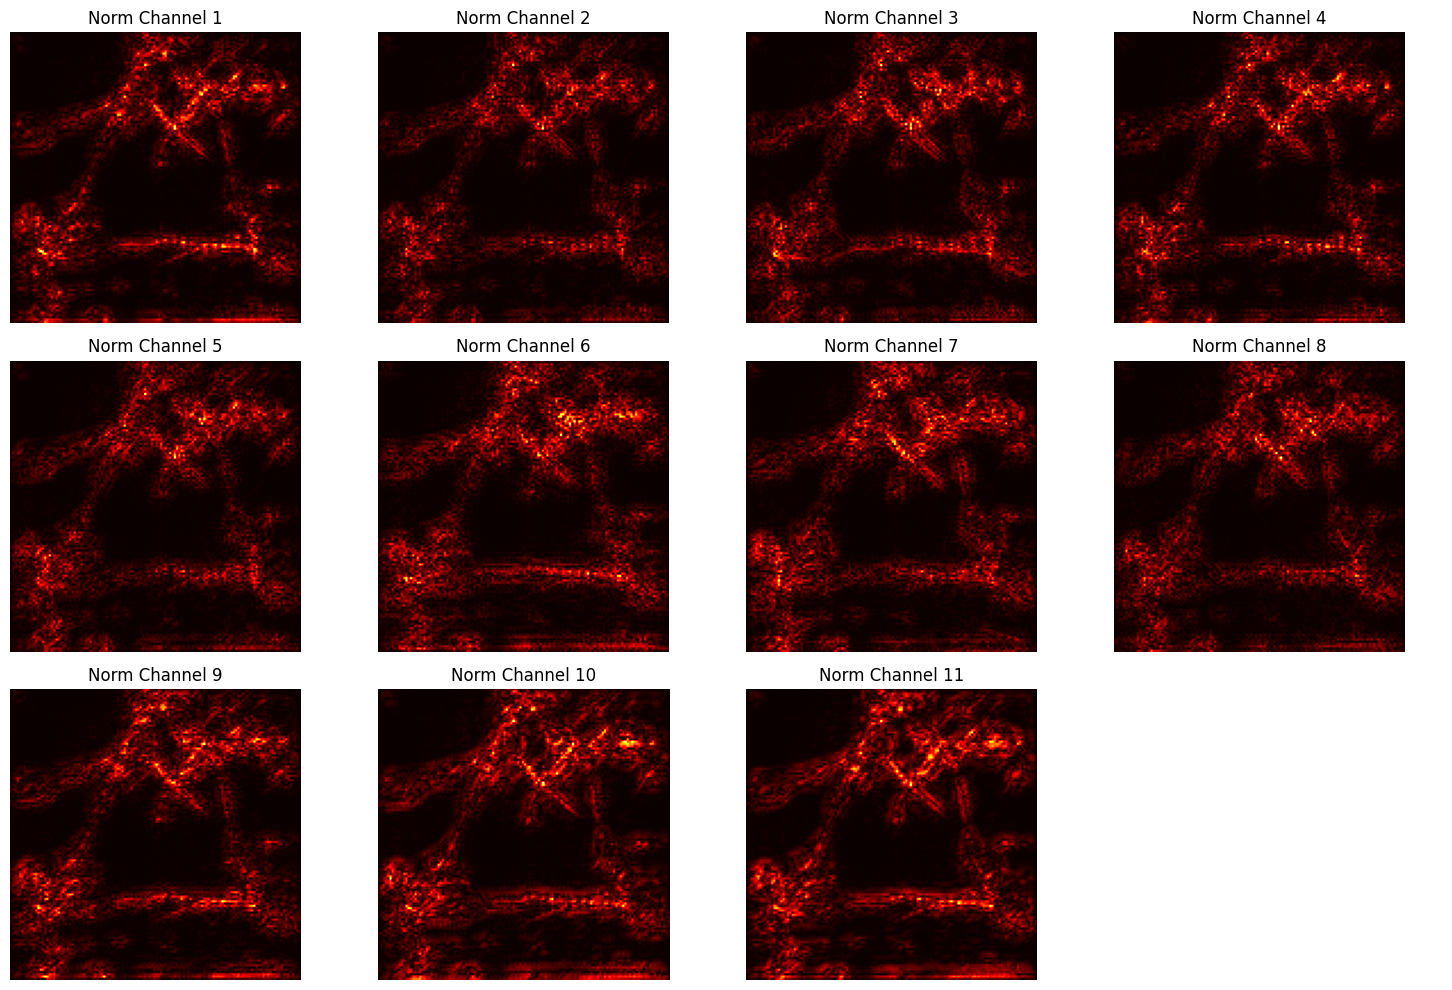

In [78]:
# Get saliency maps (absolute gradients of the input)
saliency = input_tensor.grad.abs().detach().squeeze(0)

min_saliency = 1
max_saliency = 0

# for i in range(11):
#     # print(saliency[i])

#     print(saliency[i].min(), saliency[i].max())


# Compute global min and max across all channels and pixels
min_saliency = saliency.min().item()
max_saliency = saliency.max().item()

print(min_saliency)
print(max_saliency) 

saliency_normalized = np.empty(len(saliency))

# normalization
saliency_normalized =  (saliency - min_saliency) / (max_saliency - min_saliency)

# for i in range(11):
#     # print(saliency[i])

#     print(saliency_normalized[i].min(), saliency_normalized[i].max())

# print(saliency[0]  == saliency_normalized[0])


# Plot saliency maps for each input channel
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns (extra space for 11th channel)

for i in range(11):
    row, col = divmod(i, 4)  # Compute row and column indices
    ax = axes[row, col]
    ax.imshow(saliency[i].cpu().numpy(), cmap='hot')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')


# Turn off any unused subplots (12th plot in a 3x4 layout)
if 11 < 12:
    axes[2, 3].axis('off')

plt.tight_layout()
plt.show()
 
# Plot saliency maps for each input channel
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns (extra space for 11th channel)

for i in range(11):
    row, col = divmod(i, 4)  # Compute row and column indices
    ax = axes[row, col]
    ax.imshow(saliency_normalized[i].cpu().numpy(), cmap='hot')
    ax.axis('off')
    ax.set_title(f'Norm Channel {i+1}')


# Turn off any unused subplots (12th plot in a 3x4 layout)
if 11 < 12:
    axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

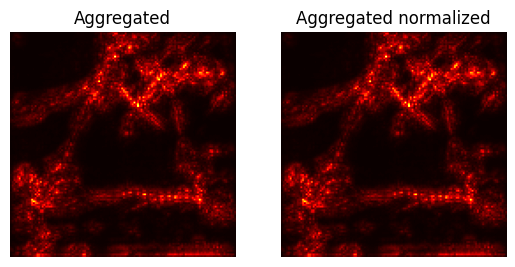

In [79]:
aggregated_saliency = saliency.sum(dim=0)  # Sum across input channels

plt.subplot(1, 2, 1)
plt.imshow(aggregated_saliency.cpu().numpy(), cmap='hot')
plt.axis('off')
plt.title("Aggregated")

# normalized aggregated saliency map
saliency_norm = saliency / saliency.max()
agg_saliency_norm = saliency_norm.sum(dim= 0)

plt.subplot(1, 2, 2)
plt.imshow(agg_saliency_norm.cpu().numpy(), cmap='hot')
plt.axis('off')
plt.title("Aggregated normalized")

plt.show()

(128, 128)


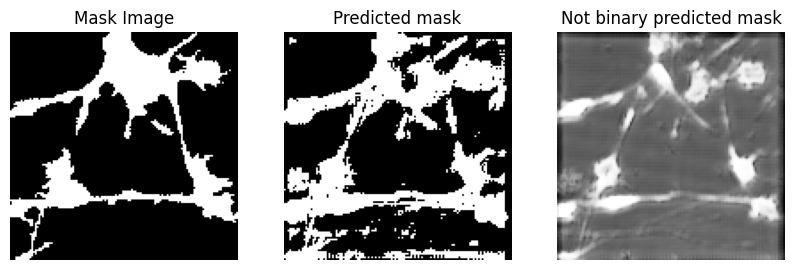

In [80]:
# print the output mask
output_mask = output.squeeze().cpu().detach().numpy()
print(output_mask.shape)

plt.figure(figsize=(10, 5))

# print the mask image
random_mask = masks[random_idx].to(device)

# Display the original output mask
plt.subplot(1, 3, 1)
plt.imshow(random_mask.cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title("Mask Image")

# Display the predicted output mask
plt.subplot(1, 3, 2)
plt.imshow(binary_output.cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title("Predicted mask")


# not binary output
plt.subplot(1, 3, 3)
plt.imshow(output.cpu().squeeze().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title("Not binary predicted mask")
plt.show()

In [81]:
# Function to compute Grad-CAM
def compute_gradcam(model, input_tensor, target_layer_name):
    gradients = []  # To store gradients
    activations = []  # To store activations

    # Hook to capture gradients and activations
    def forward_hook(module, input, output):
        activations.append(output)  # Capture the activations
        
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Capture the gradients

    # Register hooks to the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    try:
        # Forward pass
        output = model(input_tensor)

        # Target output
        masked_output = output[0, 0] * (output[0, 0] > 0.5).float()  # Mask without breaking gradients
        target = masked_output.mean()

        # Compute gradients for the target output
        model.zero_grad()  # Clear previous gradients
        target.backward()

        # Extract gradients and activations
        gradients = gradients[0].detach()  # Shape: [B, C, H, W]
        activations = activations[0].detach()  # Shape: [B, C, H, W]

        # Compute Grad-CAM weights: global average pooling of gradients
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # Shape: [B, C, 1, 1]

        # Weighted sum of activations
        gradcam = (weights * activations).sum(dim=1).squeeze()  # Shape: [H, W]

        # Apply ReLU to keep only positive contributions
        gradcam = F.relu(gradcam)

        # Normalize Grad-CAM to range [0, 1]
        gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())

        return gradcam.cpu().numpy()
    finally:
        # Ensure hooks are removed after computation
        forward_handle.remove()
        backward_handle.remove()


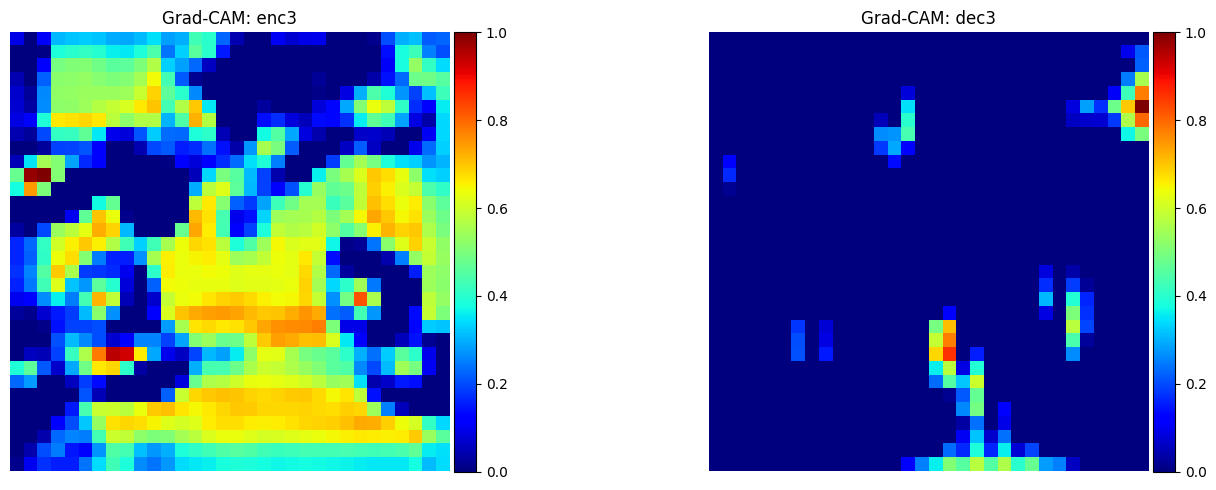

In [82]:
# Set model to evaluation mode
model.eval()

# Specify target layer 
target_layer_name_e3 = "enc3"  # layer at depth 3 in encoder
target_layer_name_d3 = "dec3"

# Compute Grad-CAM
gradcam_enc3 = compute_gradcam(model, input_tensor, target_layer_name_e3)
gradcam_dec3 = compute_gradcam(model, input_tensor, target_layer_name_d3)

# Plot Grad-CAM results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create 3 subplots

gradcam_results = [gradcam_enc3, gradcam_dec3]  # Grad-CAM heatmaps
titles = ["Grad-CAM: enc3", "Grad-CAM: dec3"]

for ax, gradcam, title in zip(axes, gradcam_results, titles):
    # Plot Grad-CAM heatmap
    im = ax.imshow(gradcam, cmap="jet")
    ax.axis("off")
    ax.set_title(title)

    # Create a colorbar proportional to the plot size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [83]:
# Function to compute Grad-CAM for each input channel separately
def compute_gradcam_per_channel(model, input_tensor, target_layer_name):
    """
    Computes Grad-CAM for each input channel separately.
    
    Args:
        model: The neural network model.
        input_tensor: The input tensor of shape [B, C, H, W].
        target_layer_name: The name of the target layer for Grad-CAM.
        
    Returns:
        gradcam_maps: A list of Grad-CAM maps for each input channel.
    """
    gradcam_maps = []
    num_channels = input_tensor.size(1)

    for channel in range(num_channels):
        gradients = []  # To store gradients
        activations = []  # To store activations

        # Hook to capture gradients and activations
        def forward_hook(module, input, output):
            activations.append(output)  # Capture the activations

        def backward_hook(module, grad_input, grad_output):
            gradients.append(grad_output[0])  # Capture the gradients

        # Register hooks to the target layer
        target_layer = dict(model.named_modules())[target_layer_name]
        forward_handle = target_layer.register_forward_hook(forward_hook)
        backward_handle = target_layer.register_backward_hook(backward_hook)

        try:
            # Forward pass with a single channel enabled
            input_tensor_channel = input_tensor.clone()
            input_tensor_channel[:, [i for i in range(num_channels) if i != channel], :, :] = 0  # Zero-out other channels
            output = model(input_tensor_channel)

            # Target output
            target = output[0, 0].mean()

            # Compute gradients for the target output
            model.zero_grad()  # Clear previous gradients
            target.backward()

            # Extract gradients and activations
            gradients_channel = gradients[0].detach()  # Shape: [B, C, H, W]
            activations_channel = activations[0].detach()  # Shape: [B, C, H, W]

            # Compute Grad-CAM weights: global average pooling of gradients
            weights = gradients_channel.mean(dim=(2, 3), keepdim=True)  # Shape: [B, C, 1, 1]

            # Weighted sum of activations
            gradcam = (weights * activations_channel).sum(dim=1).squeeze()  # Shape: [H, W]

            # Apply ReLU to keep only positive contributions
            gradcam = F.relu(gradcam)

            # Normalize Grad-CAM to range [0, 1]
            gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)
            gradcam_maps.append(gradcam.cpu().numpy())
        finally:
            # Ensure hooks are removed after computation
            forward_handle.remove()
            backward_handle.remove()

    return gradcam_maps

In [84]:
# Function to compute channel importance based on Grad-CAM maps
def compute_channel_importance(gradcam_maps):
    """
    Computes the importance of each input channel based on the Grad-CAM maps.

    Args:
        gradcam_maps: A list of Grad-CAM maps for each input channel.

    Returns:
        channel_importance: A list of importance values for each channel.
    """
    channel_importance = []

    for gradcam in gradcam_maps:
        # Sum the Grad-CAM map as a measure of importance
        importance = np.sum(gradcam)
        channel_importance.append(importance)

    # Normalize importance values to sum to 1
    channel_importance = np.array(channel_importance)
    channel_importance /= channel_importance.sum()

    return channel_importance

Grad-CAM: enc1


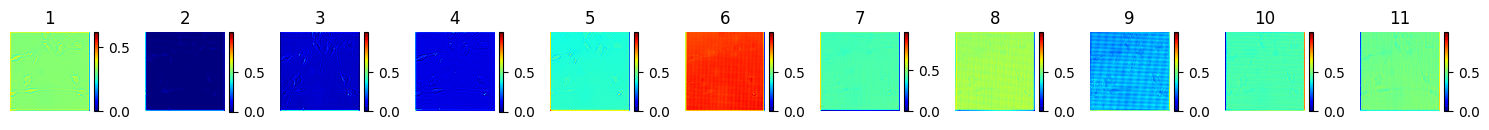

In [85]:
# Set model to evaluation mode
model.eval()

# Specify target layer 
target_layer_name_e1 = "enc1"

# Compute Grad-CAM
gradcam_maps_enc1 = compute_gradcam_per_channel(model, input_tensor, target_layer_name_e1)

# Plot Grad-CAM results
fig, axes = plt.subplots(1, 11, figsize=(15, 5))  # Create 11 subplots

print("Grad-CAM: enc1")
i = 1

for ax, gradcam in zip(axes, gradcam_maps_enc1):
    # Plot Grad-CAM heatmap
    im = ax.imshow(gradcam, cmap="jet")
    ax.axis("off")
    ax.set_title(str(i))

    # Create a colorbar proportional to the plot size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding
    plt.colorbar(im, cax=cax)

    i+=1

plt.tight_layout()
plt.show()

In [86]:
channel_importance_enc1 = compute_channel_importance(gradcam_maps_enc1)

channels_dict = {}
for i in range(11):
    channels_dict[i] = channel_importance_enc1[i]
    # sort the dictionary based on values
    sorted_channels = dict(sorted(channels_dict.items(), key=lambda item: item[1], reverse=True))

print(sorted_channels)

{5: np.float32(0.2140961), 7: np.float32(0.13785776), 10: np.float32(0.123237565), 9: np.float32(0.11022668), 6: np.float32(0.107527085), 4: np.float32(0.10115382), 0: np.float32(0.08050723), 8: np.float32(0.076571375), 3: np.float32(0.025495647), 2: np.float32(0.019247588), 1: np.float32(0.004079165)}


Grad-CAM: bottleneck


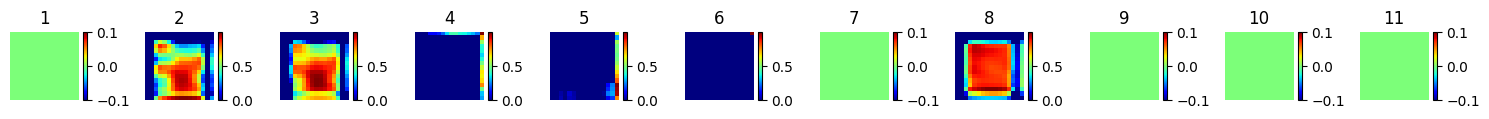

In [87]:
# Set model to evaluation mode
model.eval()

# Specify target layer 
target_layer_name_btl = "bottleneck"

# Compute Grad-CAM
gradcam_maps_btl = compute_gradcam_per_channel(model, input_tensor, target_layer_name_btl)

# Plot Grad-CAM results
fig, axes = plt.subplots(1, 11, figsize=(15, 5))  # Create 11 subplots

print("Grad-CAM: bottleneck")
i = 1

for ax, gradcam in zip(axes, gradcam_maps_btl):
    # Plot Grad-CAM heatmap
    im = ax.imshow(gradcam, cmap="jet")
    ax.axis("off")
    ax.set_title(str(i))

    # Create a colorbar proportional to the plot size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding
    plt.colorbar(im, cax=cax)

    i+=1

plt.tight_layout()
plt.show()

In [88]:
channel_importance_btl = compute_channel_importance(gradcam_maps_btl)

channels_dict = {}
for i in range(11):
    channels_dict[i] = channel_importance_btl[i]
    # sort the dictionary based on values
    sorted_channels = dict(sorted(channels_dict.items(), key=lambda item: item[1], reverse=True))

print(sorted_channels)

{7: np.float32(0.33834463), 2: np.float32(0.2990764), 1: np.float32(0.29254547), 4: np.float32(0.033836525), 3: np.float32(0.033452358), 5: np.float32(0.0027446495), 0: np.float32(0.0), 6: np.float32(0.0), 8: np.float32(0.0), 9: np.float32(0.0), 10: np.float32(0.0)}


Grad-CAM: enc3


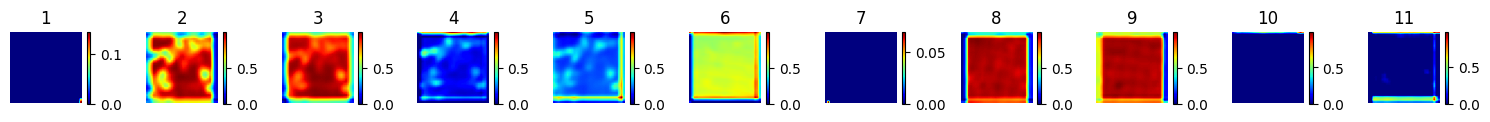

In [89]:
# Set model to evaluation mode
model.eval()

# Specify target layer 
target_layer_name_enc3 = "enc3"

# Compute Grad-CAM
gradcam_maps_enc3 = compute_gradcam_per_channel(model, input_tensor, target_layer_name_enc3)

# Plot Grad-CAM results
fig, axes = plt.subplots(1, 11, figsize=(15, 5))  # Create 11 subplots

print("Grad-CAM: enc3")
i = 1

for ax, gradcam in zip(axes, gradcam_maps_enc3):
    # Plot Grad-CAM heatmap
    im = ax.imshow(gradcam, cmap="jet")
    ax.axis("off")
    ax.set_title(str(i))

    # Create a colorbar proportional to the plot size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding
    plt.colorbar(im, cax=cax)

    i+=1

plt.tight_layout()
plt.show()

In [90]:
channel_importance_enc3 = compute_channel_importance(gradcam_maps_enc3)

channels_dict = {}
for i in range(11):
    channels_dict[i] = channel_importance_enc3[i]
    # sort the dictionary based on values
    sorted_channels = dict(sorted(channels_dict.items(), key=lambda item: item[1], reverse=True))

print(sorted_channels)

{8: np.float32(0.20039342), 2: np.float32(0.18768582), 7: np.float32(0.1852326), 1: np.float32(0.17096531), 5: np.float32(0.13315074), 4: np.float32(0.0636363), 3: np.float32(0.04014754), 10: np.float32(0.0155285), 9: np.float32(0.0031870168), 0: np.float32(5.6585213e-05), 6: np.float32(1.6228809e-05)}


In [91]:
# select target layer
target_layer_name = 'bottleneck'

random_indexes = []
channel_importances = []
for i in range(len(images)):
    random_idx = random.randint(0, images.size(0) - 1)
    random_indexes.append(random_idx)

    # Extract the random image
    random_image = images[random_idx].unsqueeze(0).to(device)  # Add batch dimension
    random_mask = masks[random_idx].to(device)  # Ground truth mask for the random sample

    # Set up input_tensor with requires_grad=True
    input_tensor = random_image.clone().detach()
    input_tensor.requires_grad = True

    gradcam_maps_btls = compute_gradcam_per_channel(model, input_tensor, target_layer_name)

    # compute channel importance
    channel_importance = compute_channel_importance(gradcam_maps_btls)
    channel_importances.append(channel_importance)


# being channel importances a list of 10 elements, each element being a list of 11 elements, compute the mean of each channel
channel_importances = np.array(channel_importances)
channel_importances_mean = np.mean(channel_importances, axis=0)

print(channel_importances_mean)

channels_dict = {}
for i in range(11):
    channels_dict[i] = channel_importances_mean[i]
    # sort the dictionary based on values
    sorted_channels = dict(sorted(channels_dict.items(), key=lambda item: item[1], reverse=True))

print(sorted_channels)
print(sorted_channels.keys())

[0.01052317 0.30612785 0.2732194  0.02465167 0.05554123 0.01061104
 0.01214744 0.2895305  0.         0.0176476  0.        ]
{1: np.float32(0.30612785), 7: np.float32(0.2895305), 2: np.float32(0.2732194), 4: np.float32(0.055541232), 3: np.float32(0.02465167), 9: np.float32(0.0176476), 6: np.float32(0.0121474415), 5: np.float32(0.010611043), 0: np.float32(0.010523168), 8: np.float32(0.0), 10: np.float32(0.0)}
dict_keys([1, 7, 2, 4, 3, 9, 6, 5, 0, 8, 10])


10 images: 
{1: np.float32(0.32425278), 6: np.float32(0.23517641), 4: np.float32(0.18213208), 3: np.float32(0.17079097), 2: np.float32(0.02571983), 0: np.float32(0.025155663), 7: np.float32(0.022498643), 8: np.float32(0.014273626), 5: np.float32(0.0), 9: np.float32(0.0), 10: np.float32(0.0)}

20 images: 
{1: np.float32(0.32119656), 6: np.float32(0.21516493), 4: np.float32(0.17474887), 3: np.float32(0.1700423), 0: np.float32(0.041530706), 2: np.float32(0.035709716), 7: np.float32(0.02782833), 8: np.float32(0.013778528), 5: np.float32(0.0), 9: np.float32(0.0), 10: np.float32(0.0)}

30 images: 
{1: np.float32(0.30926213), 6: np.float32(0.20279995), 3: np.float32(0.20192641), 4: np.float32(0.17464805), 2: np.float32(0.035781097), 0: np.float32(0.03480662), 7: np.float32(0.028024979), 8: np.float32(0.012750808), 5: np.float32(0.0), 9: np.float32(0.0), 10: np.float32(0.0)}

32 images:
{1: np.float32(0.3300703), 6: np.float32(0.2288296), 4: np.float32(0.20414677), 3: np.float32(0.19944052), 2: np.float32(0.017509643), 0: np.float32(0.009047773), 8: np.float32(0.0057743685), 7: np.float32(0.00518094), 5: np.float32(0.0), 9: np.float32(0.0), 10: np.float32(0.0)}

In [92]:
# select target layer
target_layer_name = 'enc1'

random_indexes = []
channel_importances = []
for i in range(len(images)):
    random_idx = random.randint(0, images.size(0) - 1)
    random_indexes.append(random_idx)

    # Extract the random image
    random_image = images[random_idx].unsqueeze(0).to(device)  # Add batch dimension
    random_mask = masks[random_idx].to(device)  # Ground truth mask for the random sample

    # Set up input_tensor with requires_grad=True
    input_tensor = random_image.clone().detach()
    input_tensor.requires_grad = True

    gradcam_maps_btls = compute_gradcam_per_channel(model, input_tensor, target_layer_name)

    # compute channel importance
    channel_importance = compute_channel_importance(gradcam_maps_btls)
    channel_importances.append(channel_importance)


# being channel importances a list of 10 elements, each element being a list of 11 elements, compute the mean of each channel
channel_importances = np.array(channel_importances)
channel_importances_mean = np.mean(channel_importances, axis=0)

print(channel_importances_mean)

channels_dict = {}
for i in range(11):
    channels_dict[i] = channel_importances_mean[i]
    # sort the dictionary based on values
    sorted_channels = dict(sorted(channels_dict.items(), key=lambda item: item[1], reverse=True))

print(sorted_channels)
print(sorted_channels.keys())

[0.08282507 0.00693527 0.02399754 0.02649117 0.10365    0.20724612
 0.09658425 0.14358178 0.08125436 0.10498593 0.12244852]
{5: np.float32(0.20724612), 7: np.float32(0.14358178), 10: np.float32(0.12244852), 9: np.float32(0.10498593), 4: np.float32(0.10365), 6: np.float32(0.096584246), 0: np.float32(0.08282507), 8: np.float32(0.08125436), 3: np.float32(0.026491167), 2: np.float32(0.023997542), 1: np.float32(0.0069352738)}
dict_keys([5, 7, 10, 9, 4, 6, 0, 8, 3, 2, 1])
